## Building Hidden Markov Models (*HMMs*) for speech recognition

We'll use *Gaussian HMMs* to model our data. *HMMs* are great tool for modeling time series data. As an audio signa is a time series signal, so the *HMMs* fit our needs. 

*HMMs* are popular because they can be trained automatically and are simple and computationally feasible to use. A *HMM* represent probability distrubutions over sequencs of observations.

In this document we use **hmmlearn** package built with Sphinx and **python_speech features** built for MFCC.

We need train data to build our speech recognizer. Our data set contains 41 different words, where each word has many audio files associated with it. We'll build an *HMM* model for each class by training our model on given dataset. Then after build model, given new input file, we need to run all the models on this file and pick the one with the best score.

In [2]:
import numpy as np
import os
import pandas as pd
import datetime
import math

from python_speech_features import mfcc, logfbank
import matplotlib.pyplot as plt
import pickle
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import math

from utils import *

In [3]:
# our utils functions
from utils import *

# our classes
from classes.PreprocessData import *
from classes.EvaluateModel import *

In [4]:
fpaths = []
labels = []

In [5]:
word_spoken = []
for dataset in ['ADA','']:
    dataset = '41{}'.format(dataset)
    input_folder = '..\data\{}'.format(dataset)

    # pars the input directory that contains audio files
    # get audio files and their lables

    for f in os.listdir(input_folder):
        for w in os.listdir(input_folder+'\\'+ f):
            # check wheter files is wav or not

            if (w.find('wav')!=-1):
                fpaths.append(input_folder+'\\'+f+'\\'+w)
                labels.append(f)
                if f not in word_spoken:
                    word_spoken.append(f)

In [6]:
# size of dataset
print(len(labels))

30620


In [7]:
label_set=list(set(labels))
label_set.sort()
label_set

['0_zero',
 '1_one',
 '2_two',
 '3_three',
 '4_four',
 '5_five',
 '6_six',
 '7_seven',
 '8_eight',
 '9_nine',
 'A_C Documents',
 'All switches',
 'Alternate air door',
 'Battery+Main bus',
 'Cabin doors',
 'Checked',
 'Circuit breakers',
 'Closed',
 'Cockpit',
 'Cockpit checklist completed',
 'Completed',
 'Decimal',
 'Flight Controls',
 'Fuel Quantity',
 'Fuel Selector',
 'Fuel Shutoff Valve',
 'Fuel Temperature',
 'On',
 'Seats & Belts',
 'Shut-off cabin heat',
 'Towbar',
 'Weight and balance',
 'aboard',
 'adjusted & locked',
 'in',
 'locked',
 'off',
 'open',
 'preflight inspection',
 'removed',
 'sufficient']

## Extracting frequeny domain features

At the second stage we convet a signal into the freqency domain. In monst modern speech recognitoon freqeency-domain features are used as key component. In case of multispeakers MFFC feature extraction works best. After convert a signal into a freq domain, it's requered to convert it into a useable form. **Mel Frequency Cepstral Coefficients (MFCC)** is a good way to do that. *MFCC* takes the power spectrum of a signal and then uses a combination of filter banks and disrete cosinetransform to extract pattern of phones or features.

After extracting **MFFC** features we exract data into single data matrix, and a label vector with the correct label for eac data file is ceated. 

In [9]:
from scipy.io import wavfile

data = []

# first file desitination name and index
file_name = '';
word_spoken_index = 0;

for n,file in enumerate(fpaths):

    # read file 
    sampling_freq, audio = wavfile.read(file)
    # Extract MFCC features
    mfcc_features = mfcc(audio, sampling_freq)
    data.insert(n,mfcc_features)

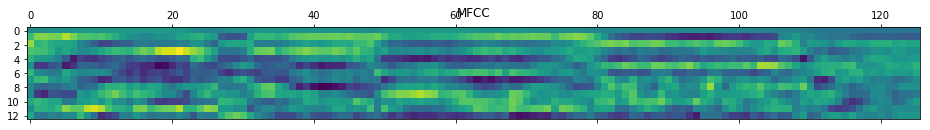

In [10]:
# plot hte MFCC features
plt.matshow(mfcc_features.T)
plt.title('MFCC')
plt.show()

In [11]:
# label datas
print('Number of files total:', len(data))
all_labels = np.zeros(len(data))
for n, l in enumerate(label_set):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 30620
Labels and label indices [ 0.  0.  0. ... 31. 31. 31.]


In [12]:
# get unique labesl
unique_words = set(all_labels)
print(unique_words)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0}


## MHH Trainer Class

In [17]:
# class to handle HMM processing
class HMMTrainer(object):  
    '''
    Parameters
    ----------
    
    n_components: parameter defines the number of hidden states
    covariance_type: defines the type of covariance in transition matrix
    n_iter: indicates the number of iterations for traning
    algorithm: decoder algorithm
    
    choice of parameters depends on the data. 
    '''
    def __init__(self, model_path, model_name='GaussianHMM', algorithm='viterbi', n_components=12, covariance_type="diag",
                 init_params="cmts", params="cmts", n_iter=1000):
        
        # initialize
        self.model_name = model_name
        self.algorithm= algorithm
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.init_params = init_params
        self.params = params
        self.n_iter = n_iter
        self.model_path = model_path
       

        # define model
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(algorithm=self.algorithm,
                                        n_components=self.n_components,
                                        covariance_type=self.covariance_type,
                                        init_params=self.init_params, 
                                        params=self.params,
                                        n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')
            
            
        if not os.path.isdir(model_path):
            raise TypeError("Path does not exists")
            
            
    # train data is 2D aray, where each frow is k-dimensions
    def train(self, X, lengths):
        # ingonre divisin by 0
        np.seterr(all='ignore')
        self.model.fit(X, lengths)
        
    # run the model on input data and get score
    def get_score(self, input_data, lenghts):
        return self.model.score(input_data, lenghts)
    
    # get probability
    def predict(self, X,lengths):
        return self.model.predict_proba(X,lengths)

    # get parametr of model
    def get_params():
        return self.model.get_params()
    
    # save model
    def save(self, label):
        with open('{path}/mix_{label}.pkl'.format(path=self.model_path, label=label), 'wb') as f:
            pickle.dump(self.model, f)

## Train Model

In [9]:
# read data
train_df = pd.read_csv('data/84new.csv')
test_df = pd.read_csv('data/84new/84new_test.csv')

In [18]:
preprocess = PreprocessData()
X_train, y_train = preprocess.preprocess_data(train_df, normalize=False)
X_test, y_test = preprocess.preprocess_data(test_df, normalize=False)
# scaler = preprocessing.StandardScaler().fit(X_train)

In [21]:
unique_words = set(y_train)

In [22]:
def clean_zeros_features(X_train, y_train, label, scaler, all_label=False):
    
    # sequence data
    X_out=[]

    
    if all_label==False:
        X=X_train[y_train == label]
    else:
        X=X_train
    
    for i, data in enumerate(X):
        for j in range(len(data)-1,0,-13):

            if(data[j]!=0):
                index = j+1
                while ((index)%13!=0):
                    index+=1

                new_data=data[0:index]

#                 var = scaler.var_
#                 mean = scaler.mean_
#                 for idx in range(index):
#                     new_data[idx]=(new_data[idx]-mean[idx])/math.sqrt(var[idx])

                new_data=np.reshape(new_data,(int(index/13),13))

                X_out.insert(i,new_data)

                break
        
    
    return np.array(X_out)

In [23]:
X_train = clean_zeros_features(X_train, y_train, None, None, all_label=True)

In [24]:
X_test = clean_zeros_features(X_test, y_test, None, None, all_label=True)

In [25]:
# hmm_models = [] # list to keep all models

# for label in unique_words:
    
    
#     if int(label)==11:
     
#         lengths = []

#         x,l=clean_zeros_features(X_train, y_train, int(label), scaler)


#         print(label)

#         # train model
#         hmm_trainer2 = HMMTrainer(model_path='models/HMMs/mix2')
#         hmm_trainer2.train(x, l)

#         # append model
#         hmm_models.append((hmm_trainer2, label))
#         # save model
#         hmm_trainer2.save(int(label))

#         hmm_trainer2 = None

In [26]:
hmm_models = [] # list to keep all models

for label in unique_words:
    
    lengths = []
    
    # get label datas
    tmp_label_data=X_train[y_train == label]
    
    # CONCATENATE TRAIN AND TEST word_data
    
    # get first concatenate
    train_data=np.array([])
    train_data=tmp_label_data[0]
    
    # get first concatenate lenght
    lengths.append(tmp_label_data[0].shape[0])
    
    for i in range(1,tmp_label_data.shape[0]):
        train_data=np.append(train_data,tmp_label_data[i],axis=0)
        lengths.append(tmp_label_data[i].shape[0])
    
    print(label)
    print(datetime.datetime.now())

    
#     # sclae values
#     scaler = StandardScaler()
#     scaler.fit(train_data)
#     train_data = scaler.transform(train_data) 
    
    # train model
    hmm_trainer = HMMTrainer(model_path='models/HMMs/84_no_norm')
    hmm_trainer.train(train_data, lengths)
    
    # append model
    hmm_models.append((hmm_trainer, label))
    # save model
    
    hmm_trainer.save(int(label))
    hmm_trainer = None

0.0
2019-02-28 17:27:53.654135


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


1.0
2019-02-28 17:29:05.061379


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


2.0
2019-02-28 17:30:04.788497


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


3.0
2019-02-28 17:31:06.159429


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


4.0
2019-02-28 17:32:20.007687


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


5.0
2019-02-28 17:34:44.150113


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


6.0
2019-02-28 17:35:36.057183


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


7.0
2019-02-28 17:36:24.016300


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


8.0
2019-02-28 17:37:42.011104


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


9.0
2019-02-28 17:38:28.526217


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


10.0
2019-02-28 17:39:17.765872


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


11.0
2019-02-28 17:41:38.260264


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


12.0
2019-02-28 17:42:58.676957


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


13.0
2019-02-28 17:44:34.711579


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


14.0
2019-02-28 17:45:59.541075


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


15.0
2019-02-28 17:46:54.215008


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


16.0
2019-02-28 17:47:58.682030


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


17.0
2019-02-28 17:49:13.602270


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


18.0
2019-02-28 17:50:37.544149


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


19.0
2019-02-28 17:53:02.580669


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


20.0
2019-02-28 17:54:45.091246


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


21.0
2019-02-28 17:55:35.814409


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


22.0
2019-02-28 17:56:40.547171


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


23.0
2019-02-28 17:59:19.973171


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


24.0
2019-02-28 18:00:12.730293


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


25.0
2019-02-28 18:00:46.622876


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


26.0
2019-02-28 18:01:25.063495


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


27.0
2019-02-28 18:02:46.811842


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


28.0
2019-02-28 18:03:28.237529


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


29.0
2019-02-28 18:04:56.831279


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


30.0
2019-02-28 18:06:00.008160


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


31.0
2019-02-28 18:06:55.900818


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


32.0
2019-02-28 18:08:08.223928


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


33.0
2019-02-28 18:09:44.138506


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


34.0
2019-02-28 18:10:20.949772


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


35.0
2019-02-28 18:11:22.628354


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


36.0
2019-02-28 18:12:32.007878


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


37.0
2019-02-28 18:13:20.972894


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


38.0
2019-02-28 18:14:28.681879


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


39.0
2019-02-28 18:15:27.903980


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


40.0
2019-02-28 18:17:21.219619


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


41.0
2019-02-28 18:18:13.742836


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


42.0
2019-02-28 18:20:54.156705


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


43.0
2019-02-28 18:21:30.198120


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


44.0
2019-02-28 18:23:17.968035


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


45.0
2019-02-28 18:24:58.109414


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


46.0
2019-02-28 18:26:15.051816


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


47.0
2019-02-28 18:28:29.581661


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


48.0
2019-02-28 18:30:09.927221


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


49.0
2019-02-28 18:30:41.853890


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


50.0
2019-02-28 18:34:11.778443


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


51.0
2019-02-28 18:35:19.786116


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


52.0
2019-02-28 18:36:15.039174


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


53.0
2019-02-28 18:37:57.585968


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


54.0
2019-02-28 18:38:34.914923


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


55.0
2019-02-28 18:39:15.953059


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


56.0
2019-02-28 18:40:25.382284


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


57.0
2019-02-28 18:41:16.860615


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


58.0
2019-02-28 18:42:27.009644


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


59.0
2019-02-28 18:42:51.201535


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


60.0
2019-02-28 18:44:25.770243


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


61.0
2019-02-28 18:46:40.805066


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


62.0
2019-02-28 18:47:50.171072


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


63.0
2019-02-28 18:48:26.559621


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


64.0
2019-02-28 18:49:22.926247


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


65.0
2019-02-28 18:50:41.310691


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


66.0
2019-02-28 18:51:48.365386


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


67.0
2019-02-28 18:52:23.872245


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


68.0
2019-02-28 18:52:48.614757


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


69.0
2019-02-28 18:53:12.562217


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


70.0
2019-02-28 18:53:35.779075


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


71.0
2019-02-28 18:54:26.652921


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


72.0
2019-02-28 18:55:28.983888


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


73.0
2019-02-28 18:56:50.828317


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


74.0
2019-02-28 18:58:29.917668


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


75.0
2019-02-28 18:59:43.577297


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


76.0
2019-02-28 19:00:44.915943


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


77.0
2019-02-28 19:03:26.216215


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


78.0
2019-02-28 19:06:48.202054


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


79.0
2019-02-28 19:09:14.730195


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


80.0
2019-02-28 19:11:02.144969


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


81.0
2019-02-28 19:13:00.757567


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


82.0
2019-02-28 19:14:08.978152


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


83.0
2019-02-28 19:15:46.446289


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


#### Train Score

In [27]:
# our classes
from PreprocessData import *
from EvaluateModel import *

In [28]:
model_grid = [
   
    {      
            'model_name' : "HMMs", 
            'api_name'   : 'hmmlearn',
            'model_type' : "onevsall", 
            'model_path' : "models/HMMs/84_no_norm", # model dir / previous set HMMs models
            'scaler_path': "",
            'dict_path'  : "dict84.txt",
            'class_size' : 84
    }

]

In [29]:
eval_model_dir = dict()

for model in model_grid:
    print(model['model_name'])
    
    # initialize evaluate model
    evaluate = EvaluateModel(model['model_name'], model['api_name'], model['model_type'], model['model_path'], model['scaler_path'], model['dict_path'], class_size=84)
    # get model
    evaluate.models = evaluate.get_models()
    # append model to dict
    eval_model_dir[model['model_name']] = evaluate

HMMs


In [30]:
import json

class_size=41

# get label dict
with open('dict41.txt', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())
    
# get labels by order
label = [data[str(i)] for i in range(class_size)]

In [32]:
logprob = np.array([[m.score(i, [i.shape[0]]) for i in X_test] for m in evaluate.models])

predicted_label = np.argmax(logprob, axis=0)
error = (predicted_label != y_test)
print('Overall test accuracy: %.2f percent' % (100 * (1 - np.mean(error))))

Overall test accuracy: 76.08 percent


#### Test Score

In [50]:
logprob = np.array([[evaluate.models[m].score(i, [i.shape[0]]) for i in [X]] for m in range(41)])

predicted_label = np.argmax(logprob, axis=0)
error = (predicted_label != y_test[0])
print('Overall test accuracy: %.2f percent' % (100 * (1 - np.mean(error))))

Overall test accuracy: 0.00 percent


In [ ]:
# plot confusion matrix
conf_mat = confusion_matrix(y_test, predicted_label)
plot_confusion_matrix(conf_mat, word_spoken, 'Prediction', 'Truth', normalize=True)

without normalizaion:
n_state=12
accuracy=91.59

without normalizaion:
n_state=12
accuracy=91.60

with normalizaion:
n_state=16
accuracy=93.62

with normalizaion:
n_state=32
accuracy=94.47




without normalizaion:
n_state=6
accuracy=83.92


with normalizaion:
n_state=6
accuracy=89.94

with normalizaion:
n_state=6 and slg=map
accuracy=89.53



# MODEL OPTIMIZATION

In this section we optimize model parameters and obtain a single, best classifier for each word.

## Model Desciption

In [ ]:
# initialize model
hmm_speech_clf = hmm.GaussianHMM(n_components=2,
                                 n_iter=1000,
                                 init_params="smtc", 
                                 params="smtc")

In [ ]:
# describe model parameters
params = hmm_speech_clf.get_params()
max_key_len = max(len(key) for key in params.keys())
max_val_len = max(len(str(val)) for val in params.values())
header = '{:<{key_width}} : {:<{val_width}}'.format(
    'Parameters',
    'Current values',
    key_width=max_key_len,
    val_width=max_val_len
)

print(header)
print('-'*len(header))
for key, val in params.items():
    print('{:{width}} : {}'.format(key, val, width=max_key_len))

## Parameters
Every possible combination selected for our Gird Seach.
Grid Search we developed does a 10-fold cross validation for each parameter configuration. Average score on a 10-fold cross validation is set as the score of that particular parameter configuration. The configuration with the highest 10-fold CV score wins.

In [ ]:
# Create the random grid
param_grid = [
    {      
            'n_components': [3, 5, 10,15],
            'covariance_type': ['diag','full'],
            'algorithm': ['viterbi', 'map']
    }
]

param_combination = []
para_label=['n_components', 'covariance_type','algorithm']

# parameter list for storing all possible combinations
param_list = []

In [ ]:
# create all possible parameters combinations for optimizations
for n_com in param_grid[0]['n_components']:
        for n_cov in param_grid[0]['covariance_type']:
            for n_alg in param_grid[0]['algorithm']:
                param_dict = dict(zip(para_label, [n_com, n_cov, n_alg]))
                param_list.append(param_dict)

## Search Parameter Space

In [ ]:
k_fold = 2 # initialsize fold number to 10

# gird search

# iterate through all labeled words
for label in unique_words:
  
    
    # seperate word_data list based on k_fold and create new word_data set
    word_data = seperate_list(X_train[y_train==label],k_fold)
    word_data = np.array(word_data)

    # create indices list for sperating word_data set 
    select=[x for x in range(k_fold)] 
    select=np.array(select)
    
    max_result=-100000000000
    # object for saving best model
    best_model= None
    
    # itereate throgh every parameter combination for every current word
    for param_i,_ in enumerate(param_list):
       
        k_fold_result=[] # list for stroing result of k_folds

        # iterate thourgh k_fold in each parameter combination
        for k in range(0,k_fold):


            # extract word_data set based on k-fold
            train  = word_data[select!=k] # k_fold-1 for train 
            test = word_data[select==k]   # 1 for test

            # CONCATENATE TRAIN AND TEST word_data
            
            # do first word_data array concatenate
            train_word_data=np.array(train[0][0])
            test_word_data=np.array(test[0][0])
            
            
            # get lenght for each test&train word_data
            lengths_train=[train[0][0].shape[0]] #get first length
            lengths_test=[test[0][0].shape[0]] #get first length


            # do the rest of concatenation for train
            for i in range(0,train.shape[0]):
                for j in range(0,train[i].shape[0]):
                    if (i!=0 or j!=0):
                        train_word_data=np.append(train_word_data,train[i][j],axis=0)
                        lengths_train.append(train[i][j].shape[0])

            # do the rest of concatenation for test
            for i in range(0,test.shape[0]):
                for j in range(0,test[i].shape[0]):
                    if (i!=0 or j!=0):
                        test_word_data=np.append(test_word_data,test[i][j],axis=0)
                        lengths_test.append(test[i][j].shape[0])
                        
                        
            # scale train word_data
            scaler = StandardScaler()
            scaler.fit(train_word_data)
            train_word_data = scaler.transform(train_word_data)
            
            # scale test word_data
            scaler = StandardScaler()
            scaler.fit(test_word_data)
            test_word_data = scaler.transform(test_word_data)

            # set parameter values to model
            hmm_trainer = HMMTrainer(n_components = param_list[param_i]['n_components'],
                                    algorithm = param_list[param_i]['algorithm'],
                                    covariance_type = param_list[param_i]['covariance_type'])
            
            
            # train model
            hmm_trainer.train(train_word_data, lengths_train)
            # get result of trained model on test set
            k_fold_result.append(hmm_trainer.get_score(test_word_data,lengths_test))

            hmm_trainer=None

        if (sum(k_fold_result)>max_result):
            max_result=sum(k_fold_result)
            best_model=hmm_trainer
            
    # save best model
    with open('{}_grid_search_cv.pkl'.format(label), 'wb') as f:
        pickle.dump(best_model, f) 
    print(best_model)